In [ ]:
! pip install pyspark

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 316.9/316.9 MB 2.8 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for pyspark: filename=pyspark-3.5.0-py2.py3-none-any.whl size=317425345 sha256=b0637b2f4eb36c66a9432b02efc01140680a71608258baabfa9a6a6e57bf93bb
  Stored in directory: /root/.cache/pip/wheels/41/4e/10/c2cf2467f71c678cfc8a6b9ac9241e5e44a01940da8fbb17fc
Successfully built pyspark


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
! pip install seaborn

In [ ]:
! pip install nltk

In [ ]:
# import packages
from pyspark.sql import SparkSession
from pyspark import SparkContext
from pyspark.sql import SQLContext
from pyspark.sql.types import *
from pyspark.sql.functions import *
from pyspark.mllib.feature import StandardScaler,PCA
from pyspark.mllib.stat import Statistics
from pyspark.ml.feature import VectorAssembler
from pyspark.sql.types import NumericType
import seaborn as sns
import matplotlib.pyplot as plt
import nltk
import pandas as pd
import itertools
from collections import Counter
from operator import itemgetter
import numpy as np
from PIL import Image
from os import path
import matplotlib.pyplot as plt
import random
from wordcloud import WordCloud, STOPWORDS
from matplotlib.pyplot import figure
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, precision_recall_curve, roc_curve
import seaborn as sns
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('vader_lexicon')
nltk.download('wordnet')



[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package vader_lexicon to /root/nltk_data...
[nltk_data] Downloading package wordnet to /root/nltk_data...


True

# Data Preparation

In [ ]:
# build spark session
spark=SparkSession.builder.appName('Amazon').getOrCreate()

In [ ]:
# Define the schema for the DataFrame
schema = StructType([
    StructField("rating", FloatType(), True),
    StructField("review_date", DateType(), True),
    StructField("asins", StringType(), True),
    StructField("review", StringType(), True),
    StructField("categories", StringType(), True)
])


In [ ]:
# read csv file using pyspark dataframe
df=spark.read.csv('/content/drive/MyDrive/CIS731/Term_Project/TermProjectData/Amazon_1125.csv',
                         header=True, schema=schema, multiLine=True,mode='DROPMALFORMED')# mode is so important that it takes me 3 hours to find the solution;(default is "PERMISSIVE"). Other options are "DROPMALFORMED" and "FAILFAST".
type(df)

pyspark.sql.dataframe.DataFrame

### Data Overview

In [ ]:
# show first 5 rows
df.show(5)

+------+-----------+----------+--------------------+----------+
|rating|review_date|     asins|              review|categories|
+------+-----------+----------+--------------------+----------+
|   5.0| 2014-11-20|B00W4YKCGC|                Good| appliance|
|   5.0| 2015-08-05|B0015UGPWQ|      Fits perfectly| appliance|
|   5.0| 2016-11-02|B001DPFP88|Worked great than...| appliance|
|   5.0| 2015-07-10|B001DPFP88|       as advertised| appliance|
|   4.0| 2018-01-15|B0014CN8Y8|Great product but...| appliance|
+------+-----------+----------+--------------------+----------+
only showing top 5 rows



In [ ]:
from pyspark.sql.functions import when

# Define the salary brackets
brackets = [(1.0, 0), (2.0, 1), (3.0, 2),(4.0, 3)]

# Start from the highest bracket
df = df.withColumn("rating_bracket", when(df["rating"] == 5.0, 4))

# Loop through the rest of the brackets
for bracket, label in reversed(brackets):
    df = df.withColumn("rating_bracket", when(df["rating"] <= bracket, label).otherwise(df["rating_bracket"]))

In [ ]:
# check schema
df.printSchema()

root
 |-- rating: float (nullable = true)
 |-- review_date: date (nullable = true)
 |-- asins: string (nullable = true)
 |-- review: string (nullable = true)
 |-- categories: string (nullable = true)
 |-- rating_bracket: integer (nullable = true)



In [ ]:
# statiscal summary
df.describe().show()

+-------+------------------+--------------------+--------------------+----------+------------------+
|summary|            rating|               asins|              review|categories|    rating_bracket|
+-------+------------------+--------------------+--------------------+----------+------------------+
|  count|             12203|               12203|               12203|     12203|             12203|
|   mean| 4.425796935179874|1.7346880024583333E9|                 3.0|      NULL|3.4257969351798736|
| stddev|1.0865495826130485| 2.512874122148298E9|                 0.0|      NULL|1.0865495826130485|
|    min|               1.0|          0321719816|                    | appliance|                 0|
|    max|               5.0|          B01HI8V10E|zipper sealed at ...|      yard|                 4|
+-------+------------------+--------------------+--------------------+----------+------------------+



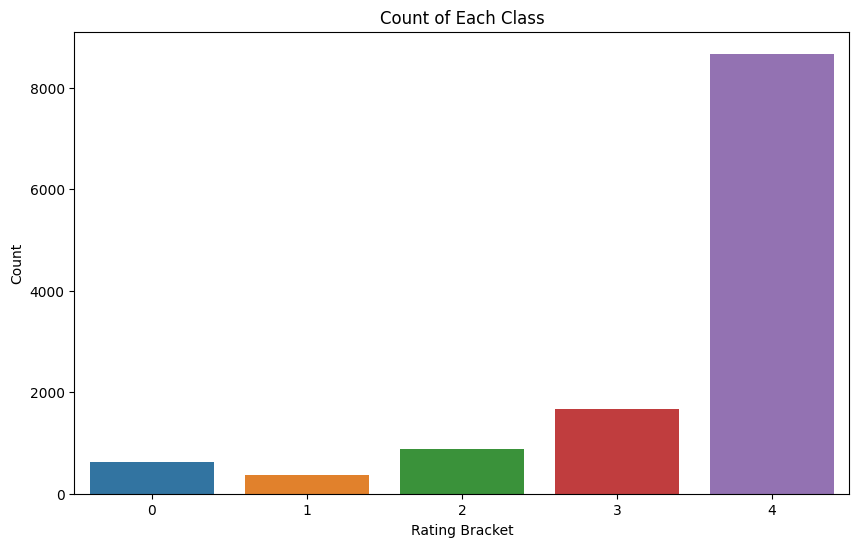

In [ ]:
import seaborn as sns

# First, group by 'income_bracket' column and count
class_counts = df.groupBy("rating_bracket").count().orderBy('rating_bracket').toPandas()

# Plot the counts of each class
plt.figure(figsize=(10,6))
sns.barplot(x='rating_bracket', y='count', data=class_counts)
plt.title('Count of Each Class')
plt.xlabel('Rating Bracket')
plt.ylabel('Count')
plt.show()

### Deal with Missing Values

In [ ]:
#Check for Missing Values
missing_values = df.select([count(when(col(c).isNull(), c)).alias(c) for c in df.columns])
print("Missing values in each column:")
missing_values.show()

Missing values in each column:
+------+-----------+-----+------+----------+--------------+
|rating|review_date|asins|review|categories|rating_bracket|
+------+-----------+-----+------+----------+--------------+
|     0|          0|    0|     0|         0|             0|
+------+-----------+-----+------+----------+--------------+



### Deal With Duplicates

In [ ]:
# Count before removing duplicates
count_before = df.count()
print(f"Count before removing duplicates: {count_before}")

# Remove duplicates
df = df.dropDuplicates()

# Count after removing duplicates
count_after = df.count()
print(f"Count after removing duplicates: {count_after}")

# Print the number of duplicates removed
print(f"Number of duplicates removed: {count_before - count_after}")

Count before removing duplicates: 12203
Count after removing duplicates: 12203
Number of duplicates removed: 0


### Data cleaning of the column 'review'

In [ ]:
# Remove characters that are not alphabets, numbers, or whitespaces
df = df.withColumn(
    "review",
    regexp_replace("review", "[^a-zA-Z0-9\s]", "")
)

# Showing the updated DataFrame
df.show(2)

+------+-----------+----------+--------------------+----------+--------------+
|rating|review_date|     asins|              review|categories|rating_bracket|
+------+-----------+----------+--------------------+----------+--------------+
|   5.0| 2016-11-11|B0092UF54A|Favorite Nikes ev...|   fashion|             4|
|   4.0| 2016-09-06|B009MA34NY|I ve worn these t...|   fashion|             3|
+------+-----------+----------+--------------------+----------+--------------+
only showing top 2 rows



# Feature Engineering

## Give the review_text a sentiment label

In [ ]:
from pyspark.sql.functions import udf
from pyspark.sql.types import StringType

import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.sentiment.vader import SentimentIntensityAnalyzer

def sentiment_analysis(text):
    if not text or not isinstance(text, str):
        return None  # Handle non-string or empty inputs

    # Tokenize and filter out stopwords
    stop_words = set(stopwords.words('english'))
    words = word_tokenize(text)
    filtered_text = ' '.join([word for word in words if word.lower() not in stop_words])

    # Analyze sentiment
    sia = SentimentIntensityAnalyzer()
    sentiment = sia.polarity_scores(filtered_text)
    return float(sentiment['compound'])  # Convert compound score to float

In [ ]:
# Register the Python function as a Spark UDF
sentiment_udf = udf(sentiment_analysis, FloatType())
# Apply the UDF to the 'review' column
df = df.withColumn("sentiment_score", sentiment_udf("review"))
# Show some results
df.show(2)

+------+-----------+----------+--------------------+----------+--------------+---------------+
|rating|review_date|     asins|              review|categories|rating_bracket|sentiment_score|
+------+-----------+----------+--------------------+----------+--------------+---------------+
|   5.0| 2016-11-11|B0092UF54A|Favorite Nikes ev...|   fashion|             4|          0.946|
|   4.0| 2016-09-06|B009MA34NY|I ve worn these t...|   fashion|             3|        -0.3612|
+------+-----------+----------+--------------------+----------+--------------+---------------+
only showing top 2 rows



## Add a column named 'product_average_rating'

In [ ]:
# Group by 'asins' and calculate the average of 'rating', then format it to one decimal place
average_ratings = df.groupBy("asins").agg(format_number(avg("rating"), 1).alias("product_average_rating"))

# Join the average ratings back to the original dataframe
df = df.join(average_ratings, on=["asins"], how="left")

# Show the results
df.show(2)


+----------+------+-----------+--------------------+----------+--------------+---------------+----------------------+
|     asins|rating|review_date|              review|categories|rating_bracket|sentiment_score|product_average_rating|
+----------+------+-----------+--------------------+----------+--------------+---------------+----------------------+
|B0092UF54A|   5.0| 2016-11-11|Favorite Nikes ev...|   fashion|             4|          0.946|                   4.4|
|B009MA34NY|   4.0| 2016-09-06|I ve worn these t...|   fashion|             3|        -0.3612|                   4.4|
+----------+------+-----------+--------------------+----------+--------------+---------------+----------------------+
only showing top 2 rows



In [ ]:
# Change the data type of column 'product_average_rating' from string to float
df = df.withColumn("product_average_rating", col("product_average_rating").cast(FloatType()))
# df = df.withColumn("sentiment_score", col("sentiment_score").cast(IntegerType()))
df.printSchema()

root
 |-- asins: string (nullable = true)
 |-- rating: float (nullable = true)
 |-- review_date: date (nullable = true)
 |-- review: string (nullable = true)
 |-- categories: string (nullable = true)
 |-- rating_bracket: integer (nullable = true)
 |-- sentiment_score: float (nullable = true)
 |-- product_average_rating: float (nullable = true)



# Exploratory Data Analysis

In [ ]:
# Count the number of reviews
total_reviews_count = df.count()

# Count the number of distinct ASINs
distinct_asins_count = df.select("asins").distinct().count()

# Count the number of distinct categories
# Assuming the column name for categories is 'categories'
distinct_categories_count = df.select("categories").distinct().count()

# Print the results
print(f"Total number of reviews: {total_reviews_count}")
print(f"Number of distinct ASINs: {distinct_asins_count}")
print(f"Number of distinct categories: {distinct_categories_count}")


Total number of reviews: 12203
Number of distinct ASINs: 4905
Number of distinct categories: 9


* We have **12,203 Reviews** and **4905 unique Products** and **9 unique categories**.

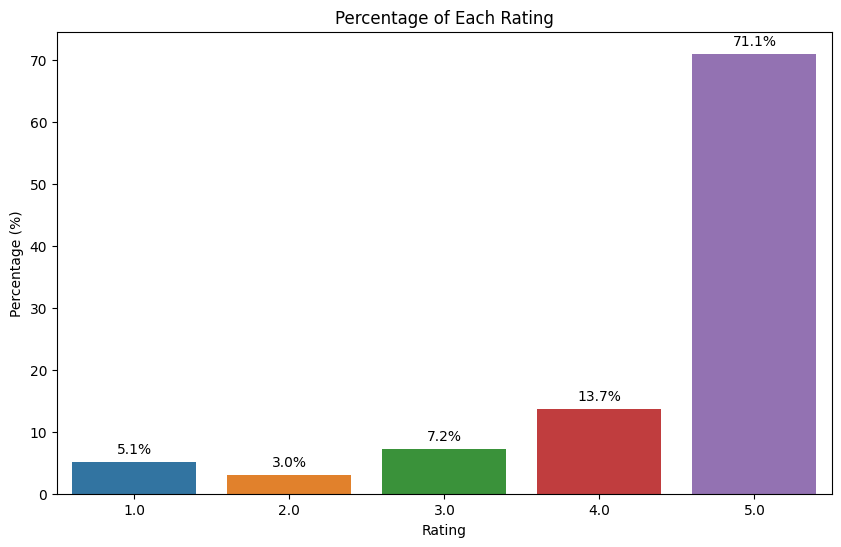

In [ ]:
from pyspark.sql.functions import col

# First, calculate the total number of ratings
total_ratings = df.count()

# Group by 'rating' column and count, then calculate the percentage
rating_percentages = df.groupBy("rating") \
                       .count() \
                       .withColumn('percentage', (col('count') / total_ratings) * 100) \
                       .orderBy('rating') \
                       .toPandas()

# Plot the percentages of each rating class
plt.figure(figsize=(10, 6))
barplot = sns.barplot(x='rating', y='percentage', data=rating_percentages)
plt.title('Percentage of Each Rating')
plt.xlabel('Rating')
plt.ylabel('Percentage (%)')

# Adding the text labels for each bar
for p in barplot.patches:
    barplot.annotate(f'{p.get_height():.1f}%',
                     (p.get_x() + p.get_width() / 2., p.get_height()),
                     ha = 'center', va = 'center',
                     xytext = (0, 9),
                     textcoords = 'offset points')

plt.show()


In [ ]:
# Find the minimum and maximum of the 'review_date' column
date_range = df.agg(min("review_date").alias("Earliest Date"), max("review_date").alias("Latest Date"))

# Show the time range
date_range.show()

+-------------+-----------+
|Earliest Date|Latest Date|
+-------------+-----------+
|   2000-12-22| 2018-09-27|
+-------------+-----------+



#### We can see that the distribution of the rating:
Percentage of rating 1: 5.1%

Percentage of rating 2: 3%

Percentage of rating 3: 7.2%

Percentage of rating 4: 13.7%

Percentage of rating 5: 71.1%


Also, We can see that the **review_date range** is **from 2000-12-22 to 2018-09-27**.

### Visualize the average rating by category

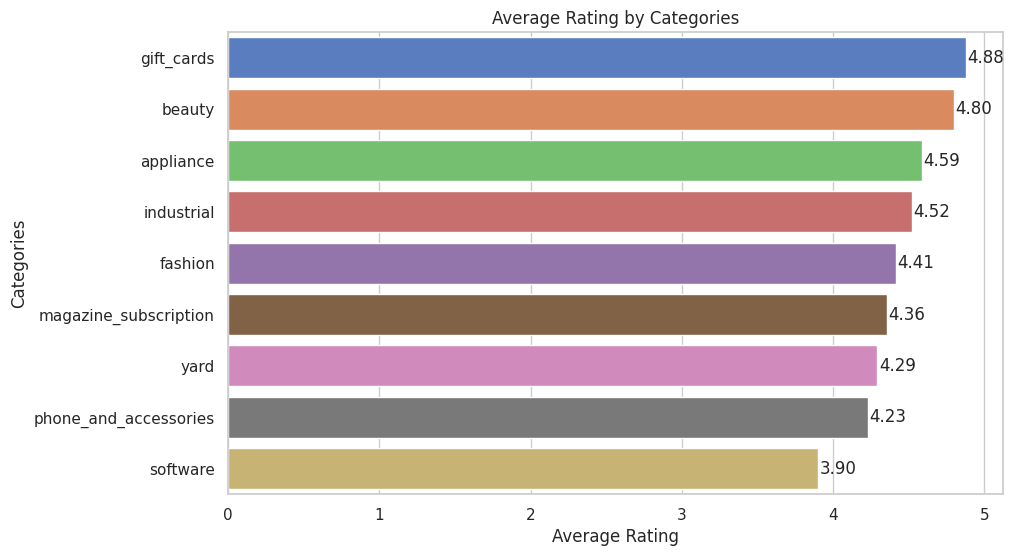

In [ ]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import avg, col
import matplotlib.pyplot as plt
import seaborn as sns

# Initialize Spark session
spark = SparkSession.builder.appName("CategoryAverageRatingDescending").getOrCreate()

# Assuming df is your PySpark DataFrame and it has been loaded already

# Calculate the average rating by categories
average_ratings_by_category = df.groupBy("categories").agg(avg("rating").alias("average_rating"))

# Sort the DataFrame in descending order of average rating
average_ratings_by_category = average_ratings_by_category.orderBy(col("average_rating").desc())

# Convert to Pandas DataFrame for visualization
pandas_df = average_ratings_by_category.toPandas()

# Visualization using Seaborn
sns.set(style="whitegrid")
plt.figure(figsize=(10, 6))

# Creating a bar plot
ax = sns.barplot(x="average_rating", y="categories", data=pandas_df, palette="muted")

plt.title('Average Rating by Categories')
plt.xlabel('Average Rating')
plt.ylabel('Categories')

# Adding labels at the end of each bar
for p in ax.patches:
    width = p.get_width()
    plt.text(width + 0.01,  # Position at end of bar
             p.get_y() + p.get_height() / 2,  # Position at center of the bar
             '{:1.2f}'.format(width),  # Value to be displayed
             va='center')

plt.show()


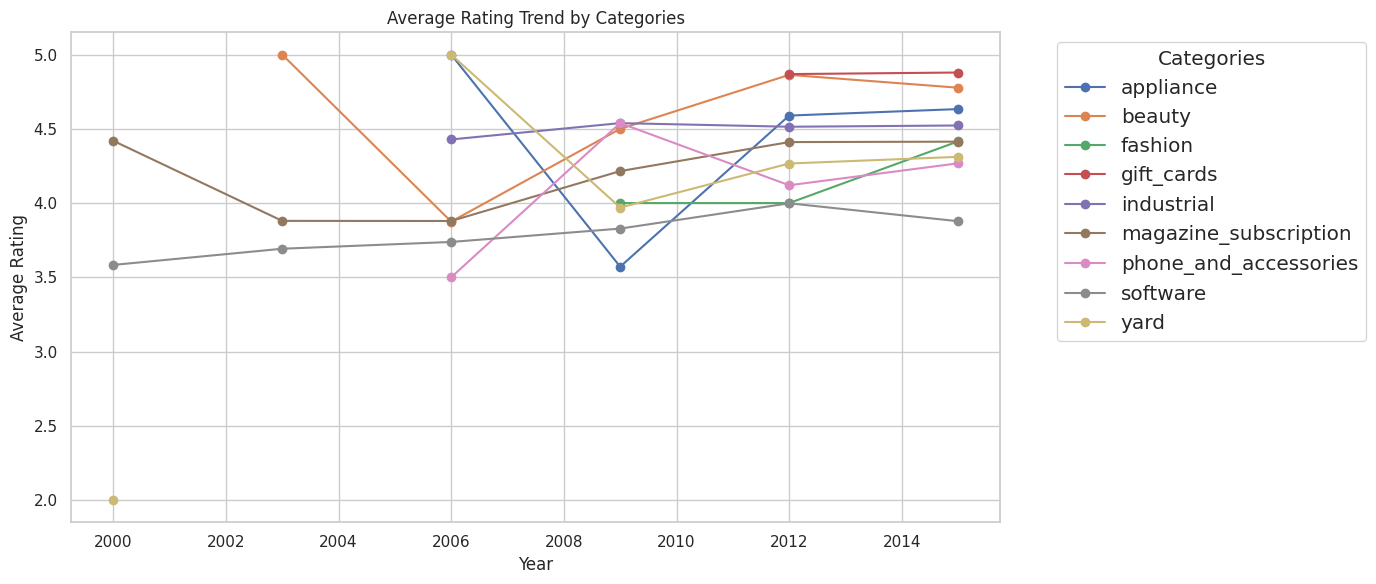

In [ ]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import avg, col, year
from pyspark.sql.window import Window
from pyspark.sql.types import IntegerType
import matplotlib.pyplot as plt
import seaborn as sns

# Initialize Spark session
spark = SparkSession.builder.appName("CategoryYearlyAverageRatingBuckets").getOrCreate()


# Extract year from review_date column
df = df.withColumn("year", year(col("review_date")))

# Find the minimum and maximum year
min_year, max_year = df.select(min("year"), max("year")).first()

# Define the bucket ranges based on min and max year
# Here we are creating 5 year buckets, adjust the ranges according to your specific needs
bucket_size = (max_year - min_year + 1) // 5
buckets = list(range(min_year, max_year, bucket_size))

# Function to assign year to a bucket
def assign_bucket(year):
    for i in range(len(buckets)):
        if year < buckets[i]:
            return buckets[i-1]
    return buckets[-1]

# Register the function as a UDF
from pyspark.sql.functions import udf
assign_bucket_udf = udf(assign_bucket, IntegerType())

# Assign each year to a bucket
df = df.withColumn("year_bucket", assign_bucket_udf(col("year")))

# Calculate the average rating by categories and year buckets
average_ratings_by_category_year_bucket = df.groupBy("categories", "year_bucket") \
                                            .agg(avg("rating").alias("average_rating")) \
                                            .orderBy("categories", "year_bucket")

# Convert to Pandas DataFrame for visualization
pandas_df = average_ratings_by_category_year_bucket.toPandas()

# Pivot the DataFrame to have categories as index, year_buckets as columns, and average_rating as values
pivot_df = pandas_df.pivot(index='categories', columns='year_bucket', values='average_rating')

# Visualization using Seaborn
sns.set(style="whitegrid")
plt.figure(figsize=(14, 6))
# Creating a line plot for each category
for category in pivot_df.index:
    plt.plot(pivot_df.columns, pivot_df.loc[category], marker='o', linestyle='-', label=category)

plt.title('Average Rating Trend by Categories')
plt.xlabel('Year')
plt.ylabel('Average Rating')

# Modify this line to adjust legend and its title size
plt.legend(title='Categories', bbox_to_anchor=(1.05, 1), loc='upper left', fontsize='large', title_fontsize='large')

# Show the plot with a tight layout to fit the legend
plt.tight_layout()
plt.show()

In [ ]:
# drop year_bucket column
df=df.drop("year_bucket")

In [ ]:
df=df.drop("year")

## Correlation Analysis

In [ ]:
df=df.drop("rating")

<ipython-input-23-2f07134f8c05>:14: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  corr_matrix = pandas_df.corr()


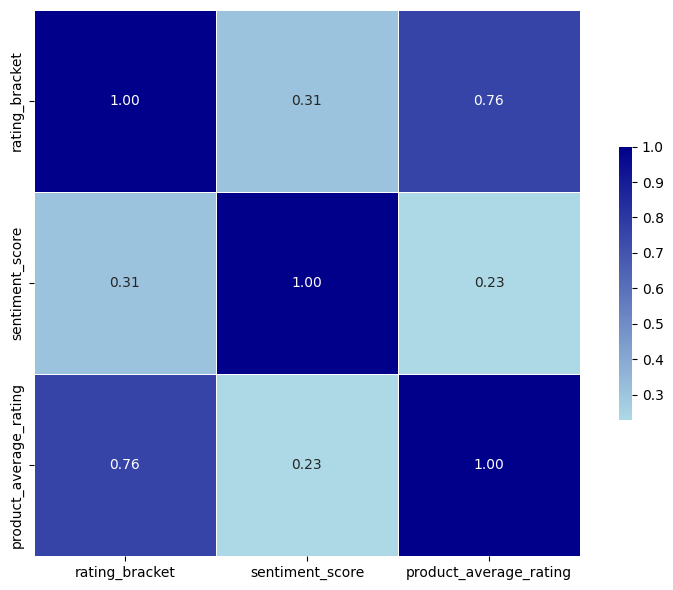

In [ ]:
from pyspark.sql import SparkSession
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap

# Initialize Spark session
spark = SparkSession.builder.appName("CorrelationHeatmap").getOrCreate()


# Convert PySpark DataFrame to Pandas DataFrame
pandas_df = df.toPandas()

# Compute the correlation matrix
corr_matrix = pandas_df.corr()

# Initialize the matplotlib figure
plt.figure(figsize=(8, 6))

# Create a custom colormap
cmap = LinearSegmentedColormap.from_list('custom_blue', ['#add8e6', '#00008b'], N=256)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap=cmap, square=True, linewidths=.5, cbar_kws={"shrink": .5})

# Adjust the plot to make sure everything fits without overlapping
plt.tight_layout()

# Show the plot
plt.show()

### Text Analytics

#### Top Words in 5-Star Reviews: Analyzing the Most Frequent Terms

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


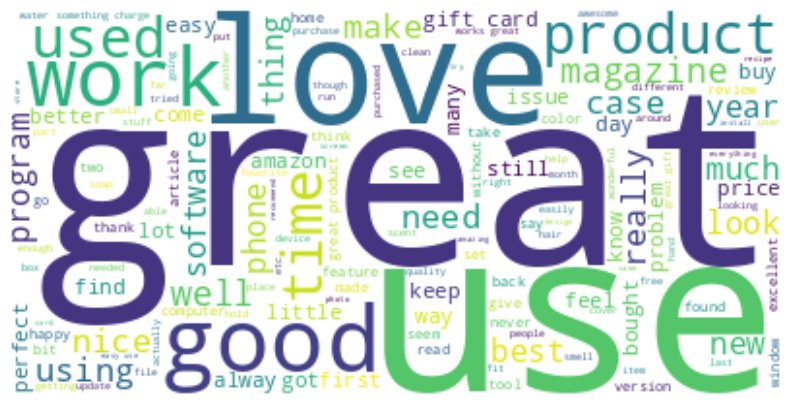

In [ ]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import col, udf
from pyspark.sql.types import StringType
from wordcloud import WordCloud
import matplotlib.pyplot as plt
import nltk
from nltk.corpus import stopwords
import string


# Download NLTK stopwords
nltk.download('stopwords')
stop_words = set(stopwords.words('english'))
# Add custom stopwords
additional_stopwords = {"one", "want", "even"}
stop_words.update(additional_stopwords)

# Function to remove punctuation and stopwords
def clean_text(text):
    text = text.lower()
    text = ''.join([char for char in text if char not in string.punctuation])
    text = ' '.join([word for word in text.split() if word not in stop_words])
    return text

# Register UDF for text cleaning
clean_text_udf = udf(clean_text, StringType())


# Filter rows where 'rating' is 5
df_5 = df.filter(col("rating") == 5)

# Clean the text
df_cleaned = df_5.withColumn("cleaned_text", clean_text_udf(col("review")))

# Collect the cleaned data for word cloud generation
texts = df_cleaned.select("cleaned_text").rdd.flatMap(lambda x: x).collect()

# Combine all texts into a single string
combined_text = " ".join(texts)

# Generating a word cloud
wordcloud = WordCloud(background_color="white").generate(combined_text)

# Display the word cloud using matplotlib
plt.figure(figsize=(10, 8))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()


#### Top Words in Reviews with Rating <=3: Analyzing the Most Frequent Terms

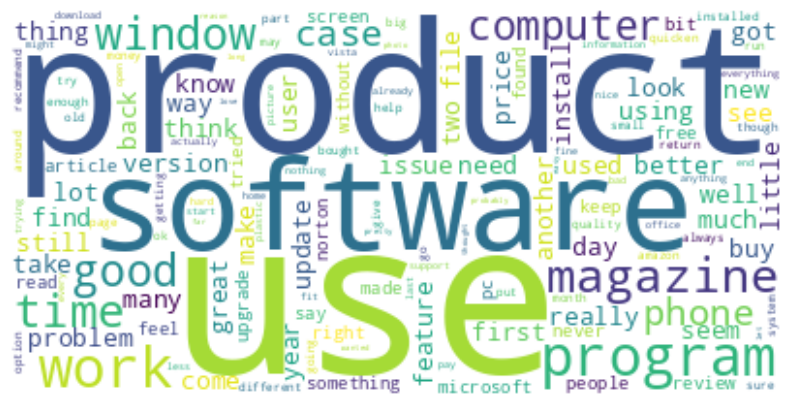

In [ ]:
# Filter rows where 'rating' lower than 3
df_3 = df.filter(col("rating") <=3)

# Clean the text
df_cleaned = df_3.withColumn("cleaned_text", clean_text_udf(col("review")))

# Collect the cleaned data for word cloud generation
texts = df_cleaned.select("cleaned_text").rdd.flatMap(lambda x: x).collect()

# Combine all texts into a single string
combined_text = " ".join(texts)

# Generating a word cloud
wordcloud = WordCloud(background_color="white").generate(combined_text)

# Display the word cloud using matplotlib
plt.figure(figsize=(10, 8))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()

### Define a function to check the rating distribution by category

In [ ]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import col
import matplotlib.pyplot as plt
import seaborn as sns
import ipywidgets as widgets
from IPython.display import display, clear_output

def plot_rating_distribution_by_category(df, categories_value):
    """
    Plots the frequency distribution of ratings for a specified 'categories' value in the DataFrame.

    :param df: PySpark DataFrame containing 'categories' and 'rating' columns.
    :param categories_value: The value of 'categories' to filter the DataFrame.
    """
    # Filter the DataFrame for the given categories value
    filtered_df = df.filter(col("categories") == categories_value)

    # Check if the filtered dataframe is not empty
    if filtered_df.count() > 0:
        # Convert to Pandas DataFrame for visualization
        pandas_df = filtered_df.toPandas()

        # Visualization using Seaborn
        sns.set(style="whitegrid", palette="pastel")
        plt.figure(figsize=(10, 6))

        # Creating a bar chart for the ratings
        ax = sns.countplot(x='rating', data=pandas_df, edgecolor="k", alpha=0.7)

        # Add titles and labels for clarity
        ax.set_title(f'Rating Frequency Distribution for Category: {categories_value}', fontsize=15)
        ax.set_xlabel('Rating', fontsize=12)
        ax.set_ylabel('Frequency', fontsize=12)

        # Improve tick marks for readability
        plt.xticks(fontsize=10)
        plt.yticks(fontsize=10)

        # Add labels to each bar
        for p in ax.patches:
            ax.annotate(format(p.get_height(), '.0f'),
                        (p.get_x() + p.get_width() / 2., p.get_height()),
                        ha='center', va='center',
                        xytext=(0, 10),
                        textcoords='offset points')

        plt.show()
    else:
        print(f"No data found for category: {categories_value}")


Text(value='software', description='category:', placeholder='Type your category')

Button(description='Visualize', style=ButtonStyle())

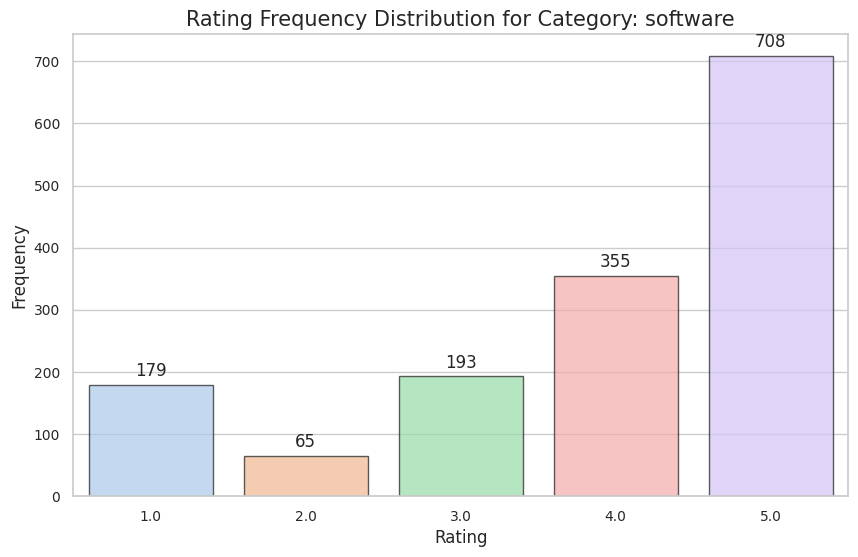

In [ ]:
# Create a text input widget for ASIN
categories_input = widgets.Text(
    value='',
    placeholder='Type your category',
    description='category:',
    disabled=False
)

# Create a button to trigger the visualization
button = widgets.Button(description="Visualize")

# Define what happens when the button is clicked
def on_button_clicked(b):
    # Clear previous output
    clear_output()

    # Display the widgets again
    display(categories_input, button)

    # Call the plot function with the user's input
    plot_rating_distribution_by_category(df, categories_input.value)

# Tell the button what to do when clicked
button.on_click(on_button_clicked)

# Display the widgets
display(categories_input, button)

### Define a function to check the rating distribution by product

In [ ]:
def plot_rating_distribution_by_product(df, asins_value):
    """
    Plots the frequency distribution of ratings for a specified 'asins' value in the DataFrame.

    :param df: PySpark DataFrame containing 'asins' and 'rating' columns.
    :param asins_value: The value of 'asins' to filter the DataFrame.
    """
    # Filter the DataFrame for the given asins value
    filtered_df = df.filter(col("asins") == asins_value)

    # Check if the filtered dataframe is not empty
    if filtered_df.count() > 0:
        # Convert to Pandas DataFrame for visualization
        pandas_df = filtered_df.toPandas()

        # Visualization using Seaborn
        sns.set(style="whitegrid", palette="pastel")
        plt.figure(figsize=(10, 6))
        # Creating a bar chart for the ratings
        ax = sns.countplot(x='rating', data=pandas_df, edgecolor="k", alpha=0.7)

        # # Creating a histogram with improved aesthetics
        # ax = sns.histplot(pandas_df['rating'].dropna(), kde=False, bins=5, edgecolor="k", alpha=0.7)

        # Add titles and labels for clarity
        ax.set_title(f'Rating Frequency Distribution for ASIN: {asins_value}', fontsize=15)
        ax.set_xlabel('Rating', fontsize=12)
        ax.set_ylabel('Frequency', fontsize=12)

        # Improve tick marks for readability
        plt.xticks(fontsize=10)
        plt.yticks(fontsize=10)

        plt.show()
    else:
        print(f"No data found for ASIN: {asins_value}")


In [ ]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import col
import matplotlib.pyplot as plt
import seaborn as sns

def plot_rating_distribution_by_product(df, asins_value):
    """
    Plots the frequency distribution of ratings for a specified 'asins' value in the DataFrame.

    :param df: PySpark DataFrame containing 'asins' and 'rating' columns.
    :param asins_value: The value of 'asins' to filter the DataFrame.
    """
    # Filter the DataFrame for the given asins value
    filtered_df = df.filter(col("asins") == asins_value)

    # Check if the filtered dataframe is not empty
    if filtered_df.count() > 0:
        # Convert to Pandas DataFrame for visualization
        pandas_df = filtered_df.toPandas()

        # Visualization using Seaborn
        sns.set(style="whitegrid", palette="pastel")
        plt.figure(figsize=(10, 6))

        # Creating a bar chart for the ratings
        ax = sns.countplot(x='rating', data=pandas_df, edgecolor="k", alpha=0.7)

        # Add titles and labels for clarity
        ax.set_title(f'Rating Frequency Distribution for ASIN: {asins_value}', fontsize=15)
        ax.set_xlabel('Rating', fontsize=12)
        ax.set_ylabel('Frequency', fontsize=12)

        # Improve tick marks for readability
        plt.xticks(fontsize=10)
        plt.yticks(fontsize=10)

        # Add labels to each bar
        for p in ax.patches:
            ax.annotate(format(p.get_height(), '.0f'),
                        (p.get_x() + p.get_width() / 2., p.get_height()),
                        ha='center', va='center',
                        xytext=(0, 10),
                        textcoords='offset points')

        plt.show()
    else:
        print(f"No data found for ASIN: {asins_value}")


Text(value='B000URXP6E', description='ASIN:', placeholder='Type your ASIN')

Button(description='Visualize', style=ButtonStyle())

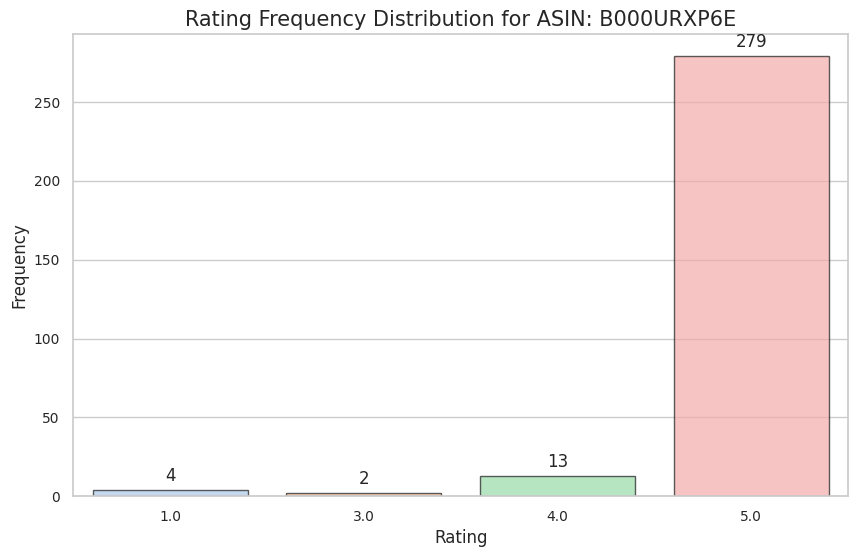

In [ ]:
# Create a text input widget for ASIN
asin_input = widgets.Text(
    value='',
    placeholder='Type your ASIN',
    description='ASIN:',
    disabled=False
)

# Create a button to trigger the visualization
button = widgets.Button(description="Visualize")

# Define what happens when the button is clicked
def on_button_clicked(b):
    # Clear previous output
    clear_output()

    # Display the widgets again
    display(asin_input, button)

    # Call the plot function with the user's input
    plot_rating_distribution_by_product(df, asin_input.value)

# Tell the button what to do when clicked
button.on_click(on_button_clicked)

# Display the widgets
display(asin_input, button)

In [ ]:
df.printSchema()

root
 |-- asins: string (nullable = true)
 |-- review_date: date (nullable = true)
 |-- review: string (nullable = true)
 |-- categories: string (nullable = true)
 |-- rating_bracket: integer (nullable = true)
 |-- sentiment_score: float (nullable = true)
 |-- product_average_rating: float (nullable = true)



# Machine Learning

### One Hot Encoding

In [ ]:
from pyspark.ml import Pipeline
from pyspark.ml.feature import StringIndexer, OneHotEncoder, VectorAssembler, Tokenizer, StopWordsRemover, HashingTF, IDF
from pyspark.ml.classification import DecisionTreeClassifier, RandomForestClassifier, NaiveBayes, OneVsRest, LinearSVC, LogisticRegression
from pyspark.ml.evaluation import MulticlassClassificationEvaluator

In [ ]:
# List of string columns to transform
columns_to_transform = ['asins','categories']

# String Indexing for specified categorical columns
indexers = [StringIndexer(inputCol=column, outputCol=column+"_index", handleInvalid="keep").fit(df) for column in columns_to_transform]

# One Hot Encoding for the indexed categorical columns
encoders = [OneHotEncoder(inputCol=column+"_index", outputCol= column+"_ohe") for column in columns_to_transform]

# Pipeline stages
stages = indexers + encoders

# Creating the pipeline
pipeline = Pipeline(stages=stages)

# Transforming the data
df = pipeline.fit(df).transform(df)

# Print the schema to see the transformed columns
df.printSchema()

root
 |-- asins: string (nullable = true)
 |-- review_date: date (nullable = true)
 |-- review: string (nullable = true)
 |-- categories: string (nullable = true)
 |-- rating_bracket: integer (nullable = true)
 |-- sentiment_score: float (nullable = true)
 |-- product_average_rating: float (nullable = true)
 |-- asins_index: double (nullable = false)
 |-- categories_index: double (nullable = false)
 |-- asins_ohe: vector (nullable = true)
 |-- categories_ohe: vector (nullable = true)



In [ ]:
# drop original categorical columns
columns_to_drop = ['asins','categories']

# Dropping specified columns from the DataFrame
df = df.drop(*columns_to_drop)

# Print the schema to see the remaining columns
df.printSchema()

root
 |-- review_date: date (nullable = true)
 |-- review: string (nullable = true)
 |-- rating_bracket: integer (nullable = true)
 |-- sentiment_score: float (nullable = true)
 |-- product_average_rating: float (nullable = true)
 |-- asins_index: double (nullable = false)
 |-- categories_index: double (nullable = false)
 |-- asins_ohe: vector (nullable = true)
 |-- categories_ohe: vector (nullable = true)



In [ ]:
# Dropping original categorical index columns
for column in df.columns:
    if column.endswith('_index'):
        df = df.drop(column)

df.printSchema()

root
 |-- review_date: date (nullable = true)
 |-- review: string (nullable = true)
 |-- rating_bracket: integer (nullable = true)
 |-- sentiment_score: float (nullable = true)
 |-- product_average_rating: float (nullable = true)
 |-- asins_ohe: vector (nullable = true)
 |-- categories_ohe: vector (nullable = true)



### Train-Test Split

In [ ]:
# Train-test split
train_data, test_data = df.randomSplit([0.8, 0.2], seed=42)

In [ ]:
train_data.show()

+-----------+--------------------+--------------+---------------+----------------------+-------------------+--------------+
|review_date|              review|rating_bracket|sentiment_score|product_average_rating|          asins_ohe|categories_ohe|
+-----------+--------------------+--------------+---------------+----------------------+-------------------+--------------+
| 2000-12-22|It is worst piece...|             0|        -0.9231|                   1.0|(4905,[1185],[1.0])| (9,[6],[1.0])|
| 2001-10-10|This review is ba...|             4|          0.923|                   5.0|(4905,[1228],[1.0])| (9,[6],[1.0])|
| 2001-12-12|I like this magaz...|             3|         0.9753|                   4.2| (4905,[259],[1.0])| (9,[4],[1.0])|
| 2002-01-24|If you are a casu...|             3|          0.982|                   4.0|(4905,[1231],[1.0])| (9,[6],[1.0])|
| 2002-01-29|As a subscriber t...|             4|         0.9252|                   3.4| (4905,[260],[1.0])| (9,[4],[1.0])|
| 2002-0

In [ ]:
df.show(2)

+-----------+--------------------+--------------+---------------+----------------------+----------------+--------------+
|review_date|              review|rating_bracket|sentiment_score|product_average_rating|       asins_ohe|categories_ohe|
+-----------+--------------------+--------------+---------------+----------------------+----------------+--------------+
| 2016-11-11|Favorite Nikes ev...|             4|          0.946|                   4.4|(4905,[4],[1.0])| (9,[1],[1.0])|
| 2016-09-06|I ve worn these t...|             3|        -0.3612|                   4.4|(4905,[9],[1.0])| (9,[1],[1.0])|
+-----------+--------------------+--------------+---------------+----------------------+----------------+--------------+
only showing top 2 rows



## Baseline Model (Logistic Regression with features of 'asins' and 'categories')

In [ ]:
from pyspark.ml import Pipeline
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.classification import LogisticRegression, NaiveBayes, DecisionTreeClassifier
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, precision_recall_curve, roc_curve
import seaborn as sns

In [ ]:

# VectorAssembler to combine feature columns
assembler = VectorAssembler(inputCols=["asins_ohe", "categories_ohe"], outputCol="features")

# Define the models
models = {
    "Logistic Regression Classifier": LogisticRegression(featuresCol='features', labelCol='rating_bracket'),
    "NaiveBayes Classifier": NaiveBayes(featuresCol='features', labelCol='rating_bracket'),
    "Decision Tree Classifier": DecisionTreeClassifier(featuresCol='features', labelCol='rating_bracket')
}

# Define evaluators
evaluator_accuracy = MulticlassClassificationEvaluator(predictionCol="prediction", labelCol='rating_bracket', metricName="accuracy")
evaluator_f1 = MulticlassClassificationEvaluator(predictionCol="prediction", labelCol='rating_bracket', metricName="f1")
evaluator_precision = MulticlassClassificationEvaluator(predictionCol="prediction", labelCol='rating_bracket', metricName="weightedPrecision")
evaluator_recall = MulticlassClassificationEvaluator(predictionCol="prediction", labelCol='rating_bracket', metricName="weightedRecall")

# Assuming train_data and test_data are already defined

# Loop through models
for model_name, model in models.items():
    # Pipeline combining preprocessing and model
    pipeline = Pipeline(stages=[assembler, model])

    # Fit the model
    pipeline_model = pipeline.fit(train_data)

    # Predict on test data
    test_results = pipeline_model.transform(test_data)

    # Compute accuracy, F1 score, precision, and recall
    accuracy = evaluator_accuracy.evaluate(test_results)
    f1 = evaluator_f1.evaluate(test_results)
    precision = evaluator_precision.evaluate(test_results)
    recall = evaluator_recall.evaluate(test_results)

    # Print evaluation metrics
    print(f"{model_name}: Test Accuracy = {accuracy}, Test F1 = {f1}, Test Precision = {precision}, Test Recall = {recall}")


Logistic Regression Classifier: Test Accuracy = 0.6904962153069807, Test F1 = 0.6118003622632016, Test Precision = 0.5815230614017369, Test Recall = 0.6904962153069807
NaiveBayes Classifier: Test Accuracy = 0.7081581160639192, Test F1 = 0.5982769391973505, Test Precision = 0.5551557872712098, Test Recall = 0.7081581160639192
Decision Tree Classifier: Test Accuracy = 0.7060555088309504, Test F1 = 0.584753884562976, Test Precision = 0.4990211421270495, Test Recall = 0.7060555088309504


## Model--- Multiclass Linear SVM with Review Features

In [ ]:
# Text processing for 'review' column
tokenizer = Tokenizer(inputCol="review", outputCol="review_words")
remover = StopWordsRemover(inputCol="review_words", outputCol="filtered_words")
hashingTF = HashingTF(inputCol="filtered_words", outputCol="review_features")

In [ ]:
# VectorAssembler to combine feature columns
assembler = VectorAssembler(inputCols=["review_features","asins_ohe", "categories_ohe"], outputCol="features")
# Base classifier for OneVsRest
base_classifier = LinearSVC()

# Define the models
models = {
    "Multiclass Linear SVM": OneVsRest(classifier=base_classifier, featuresCol='features', labelCol='rating_bracket')
    }
# Define evaluators
evaluator_accuracy = MulticlassClassificationEvaluator(predictionCol="prediction", labelCol='rating_bracket', metricName="accuracy")
evaluator_f1 = MulticlassClassificationEvaluator(predictionCol="prediction", labelCol='rating_bracket', metricName="f1")
evaluator_precision = MulticlassClassificationEvaluator(predictionCol="prediction", labelCol='rating_bracket', metricName="weightedPrecision")
evaluator_recall = MulticlassClassificationEvaluator(predictionCol="prediction", labelCol='rating_bracket', metricName="weightedRecall")

# Loop through models
for model_name, model in models.items():
    # Pipeline combining preprocessing and model
    pipeline = Pipeline(stages=[tokenizer, remover, hashingTF, assembler, model])

    # Fit the model
    pipeline_model = pipeline.fit(train_data)

    # Predict on train and test data
    test_results = pipeline_model.transform(test_data)
    train_results = pipeline_model.transform(train_data)

    # Compute accuracy, F1 score, precision, and recall
    accuracy = evaluator_accuracy.evaluate(test_results)
    f1 = evaluator_f1.evaluate(test_results)
    precision = evaluator_precision.evaluate(test_results)
    recall = evaluator_recall.evaluate(test_results)


    # Print evaluation metrics
    print(f"{model_name}: Test Accuracy = {accuracy}, Test F1 = {f1}")
    print(f"{model_name}:Test Precision = {precision}, Test Recall = {recall}")


Multiclass Linear SVM: Test Accuracy = 0.7220353238015139, Test F1 = 0.7146123361451047
Multiclass Linear SVM:Test Precision = 0.7085855110330307, Test Recall = 0.7220353238015139


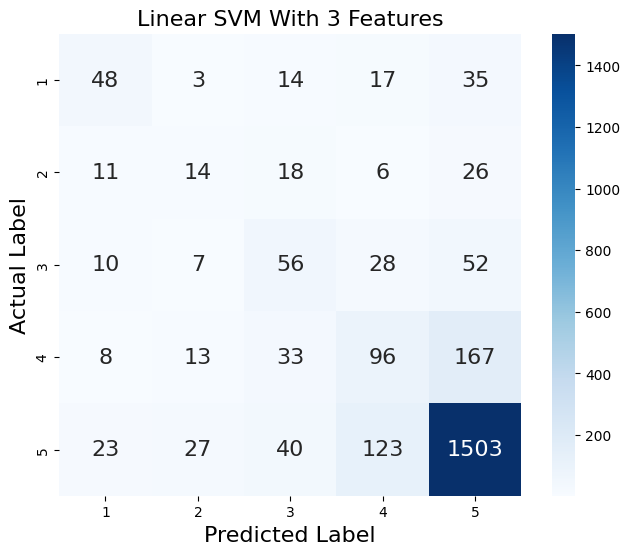

In [ ]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, precision_recall_curve, roc_curve
import seaborn as sns

# Define a function to map the numeric labels to bin ranges
def map_label_to_range(label):
  if label == 0:
      return '1'
  elif label == 1:
      return '2'
  elif label == 2:
      return '3'
  elif label == 3:
      return '4'
  elif label == 4:
      return '5'

# Apply the function to both actual and predicted labels
predictions_pd1 = test_results.select('rating_bracket', 'prediction').toPandas()
predictions_pd1.to_csv('SVM_3features.csv', index=False)
predictions_pd1['rating_bracket'] = predictions_pd1['rating_bracket'].apply(map_label_to_range)
predictions_pd1['prediction'] = predictions_pd1['prediction'].apply(map_label_to_range)
# Define labels in the desired order
labels = ['1', '2', '3', '4', '5']

# Confusion Matrix
plt.figure(figsize=(8, 6))
cm = confusion_matrix(predictions_pd1['rating_bracket'], predictions_pd1['prediction'], labels=labels)
sns.heatmap(cm, annot=True, fmt="d", square=True, cmap='Blues', xticklabels=labels, yticklabels=labels,annot_kws={"size": 16})
plt.ylabel('Actual Label',fontsize=16)
plt.xlabel('Predicted Label',fontsize=16)
plt.title('Linear SVM With 3 Features',fontsize=16)
plt.show()

## Model--- Multiclass Linear SVM with Review and Sentiment Features

In [ ]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, precision_recall_curve, roc_curve
import seaborn as sns
# VectorAssembler to combine feature columns
assembler = VectorAssembler(inputCols=["review_features","asins_ohe", "categories_ohe","sentiment_score"], outputCol="features")
# Base classifier for OneVsRest
base_classifier = LinearSVC()

# Define the models
models = {
    "Multiclass Linear SVM": OneVsRest(classifier=base_classifier, featuresCol='features', labelCol='rating_bracket')
    }
# Define evaluators
evaluator_accuracy = MulticlassClassificationEvaluator(predictionCol="prediction", labelCol='rating_bracket', metricName="accuracy")
evaluator_f1 = MulticlassClassificationEvaluator(predictionCol="prediction", labelCol='rating_bracket', metricName="f1")
evaluator_precision = MulticlassClassificationEvaluator(predictionCol="prediction", labelCol='rating_bracket', metricName="weightedPrecision")
evaluator_recall = MulticlassClassificationEvaluator(predictionCol="prediction", labelCol='rating_bracket', metricName="weightedRecall")

# Loop through models
for model_name, model in models.items():
    # Pipeline combining preprocessing and model
    pipeline = Pipeline(stages=[tokenizer, remover, hashingTF, assembler, model])

    # Fit the model
    pipeline_model = pipeline.fit(train_data)

    # Predict on train and test data
    test_results = pipeline_model.transform(test_data)
    train_results = pipeline_model.transform(train_data)

    # Compute accuracy, F1 score, precision, and recall
    accuracy = evaluator_accuracy.evaluate(test_results)
    f1 = evaluator_f1.evaluate(test_results)
    precision = evaluator_precision.evaluate(test_results)
    recall = evaluator_recall.evaluate(test_results)


    # Print evaluation metrics
    print(f"{model_name}: Test Accuracy = {accuracy}, Test F1 = {f1}")
    print(f"{model_name}:Test Precision = {precision}, Test Recall = {recall}")

Multiclass Linear SVM: Test Accuracy = 0.7224558452481077, Test F1 = 0.7132592719841729
Multiclass Linear SVM:Test Precision = 0.7056575267079154, Test Recall = 0.7224558452481077


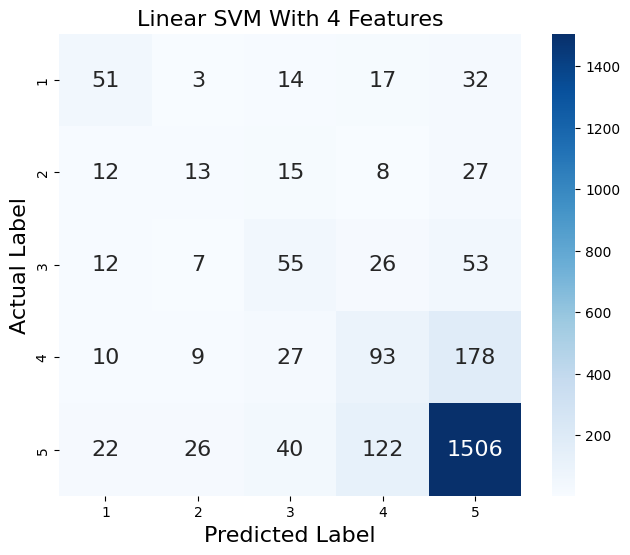

In [ ]:
# Define a function to map the numeric labels to bin ranges
def map_label_to_range(label):
  if label == 0:
      return '1'
  elif label == 1:
      return '2'
  elif label == 2:
      return '3'
  elif label == 3:
      return '4'
  elif label == 4:
      return '5'
# Prepare data for confusion matrix
predictions_pd2 = test_results.select('rating_bracket', 'prediction').toPandas()
predictions_pd2.to_csv('SVM_4features.csv', index=False)
predictions_pd2['rating_bracket'] = predictions_pd2['rating_bracket'].apply(map_label_to_range)
predictions_pd2['prediction'] = predictions_pd2['prediction'].apply(map_label_to_range)

# Define labels in the desired order
labels = ['1', '2', '3', '4', '5']

# Plot Confusion Matrix
plt.figure(figsize=(8, 6))
cm = confusion_matrix(predictions_pd2['rating_bracket'], predictions_pd2['prediction'], labels=labels)
sns.heatmap(cm, annot=True, fmt="d", square=True, cmap='Blues', xticklabels=labels, yticklabels=labels,annot_kws={"size": 16})
plt.ylabel('Actual Label', fontsize=16)
plt.xlabel('Predicted Label', fontsize=16)
plt.title('Linear SVM With 4 Features', fontsize=16)
plt.show()

## Models--- Logistic Regression with Review Features

In [ ]:
# Text processing for 'review' column
tokenizer = Tokenizer(inputCol="review", outputCol="review_words")
remover = StopWordsRemover(inputCol="review_words", outputCol="filtered_words")
hashingTF = HashingTF(inputCol="filtered_words", outputCol="review_features")

In [ ]:
# VectorAssembler to combine feature columns
assembler = VectorAssembler(inputCols=["review_features","asins_ohe", "categories_ohe"], outputCol="features")
# Define the models
models = {
      "Logistic Regression Classifier": LogisticRegression(featuresCol='features', labelCol='rating_bracket')}
# Define evaluators
evaluator_accuracy = MulticlassClassificationEvaluator(predictionCol="prediction", labelCol='rating_bracket', metricName="accuracy")
evaluator_f1 = MulticlassClassificationEvaluator(predictionCol="prediction", labelCol='rating_bracket', metricName="f1")
evaluator_precision = MulticlassClassificationEvaluator(predictionCol="prediction", labelCol='rating_bracket', metricName="weightedPrecision")
evaluator_recall = MulticlassClassificationEvaluator(predictionCol="prediction", labelCol='rating_bracket', metricName="weightedRecall")

# Assuming train_data and test_data are already defined
# Loop through models
for model_name, model in models.items():
    # Pipeline combining preprocessing and model
    pipeline = Pipeline(stages=[tokenizer, remover, hashingTF, assembler, model])

    # Fit the model
    pipeline_model = pipeline.fit(train_data)

    # Predict on train and test data
    test_results = pipeline_model.transform(test_data)
    train_results = pipeline_model.transform(train_data)

    # Compute accuracy and F1 score
    accuracy = evaluator_accuracy.evaluate(test_results)
    f1 = evaluator_f1.evaluate(test_results)
    precision = evaluator_precision.evaluate(test_results)
    recall = evaluator_recall.evaluate(test_results)

    # Print evaluation metrics
    print(f"{model_name}: Test Accuracy = {accuracy}, Test F1 = {f1}")
    print(f"{model_name}:Test Precision = {precision}, Test Recall = {recall}")

Logistic Regression Classifier: Test Accuracy = 0.6698906644238857, Test F1 = 0.6753435786629923
Logistic Regression Classifier:Test Precision = 0.6836252326536701, Test Recall = 0.6698906644238856


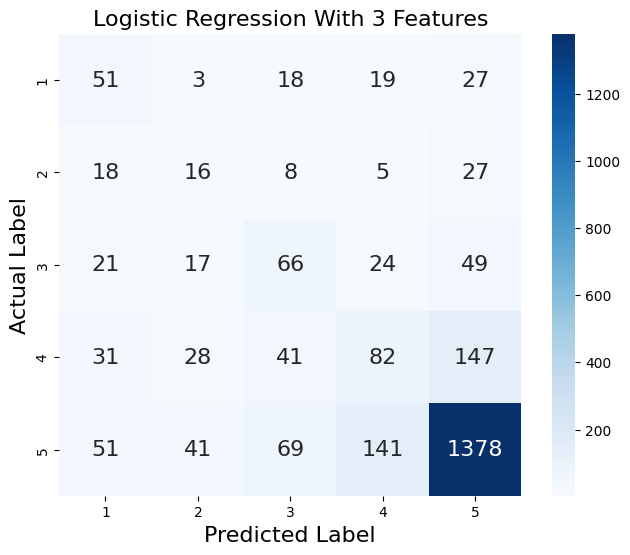

In [ ]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, precision_recall_curve, roc_curve
import seaborn as sns
# Define a function to map the numeric labels to bin ranges
def map_label_to_range(label):
  if label == 0:
      return '1'
  elif label == 1:
      return '2'
  elif label == 2:
      return '3'
  elif label == 3:
      return '4'
  elif label == 4:
      return '5'
# Prepare data for confusion matrix
predictions_pd3 = test_results.select('rating_bracket', 'prediction').toPandas()
predictions_pd3.to_csv('LR_3features.csv', index=False)
predictions_pd3['rating_bracket'] = predictions_pd3['rating_bracket'].apply(map_label_to_range)
predictions_pd3['prediction'] = predictions_pd3['prediction'].apply(map_label_to_range)

# Define labels in the desired order
labels = ['1', '2', '3', '4', '5']

# Plot Confusion Matrix
plt.figure(figsize=(8, 6))
cm = confusion_matrix(predictions_pd3['rating_bracket'], predictions_pd3['prediction'], labels=labels)
sns.heatmap(cm, annot=True, fmt="d", square=True, cmap='Blues', xticklabels=labels, yticklabels=labels,annot_kws={"size": 16})
plt.ylabel('Actual Label', fontsize=16)
plt.xlabel('Predicted Label', fontsize=16)
plt.title('Logistic Regression With 3 Features', fontsize=16)
plt.show()

## Models--- Logistic Regression witn Review and Sentiment Features

In [ ]:
# VectorAssembler to combine feature columns
assembler = VectorAssembler(inputCols=["review_features","asins_ohe", "categories_ohe","sentiment_score"], outputCol="features")
# Define the models
models = {
      "Logistic Regression Classifier": LogisticRegression(featuresCol='features', labelCol='rating_bracket')}
# Define evaluators
evaluator_accuracy = MulticlassClassificationEvaluator(predictionCol="prediction", labelCol='rating_bracket', metricName="accuracy")
evaluator_f1 = MulticlassClassificationEvaluator(predictionCol="prediction", labelCol='rating_bracket', metricName="f1")
evaluator_precision = MulticlassClassificationEvaluator(predictionCol="prediction", labelCol='rating_bracket', metricName="weightedPrecision")
evaluator_recall = MulticlassClassificationEvaluator(predictionCol="prediction", labelCol='rating_bracket', metricName="weightedRecall")

# Assuming train_data and test_data are already defined
# Loop through models
for model_name, model in models.items():
    # Pipeline combining preprocessing and model
    pipeline = Pipeline(stages=[tokenizer, remover, hashingTF, assembler, model])

    # Fit the model
    pipeline_model = pipeline.fit(train_data)

    # Predict on train and test data
    test_results = pipeline_model.transform(test_data)
    train_results = pipeline_model.transform(train_data)

    # Compute accuracy and F1 score
    accuracy = evaluator_accuracy.evaluate(test_results)
    f1 = evaluator_f1.evaluate(test_results)
    precision = evaluator_precision.evaluate(test_results)
    recall = evaluator_recall.evaluate(test_results)

    # Print evaluation metrics
    print(f"{model_name}: Test Accuracy = {accuracy}, Test F1 = {f1}")
    print(f"{model_name}:Test Precision = {precision}, Test Recall = {recall}")

Logistic Regression Classifier: Test Accuracy = 0.6669470142977292, Test F1 = 0.6736538363725161
Logistic Regression Classifier:Test Precision = 0.6835145699072225, Test Recall = 0.6669470142977292


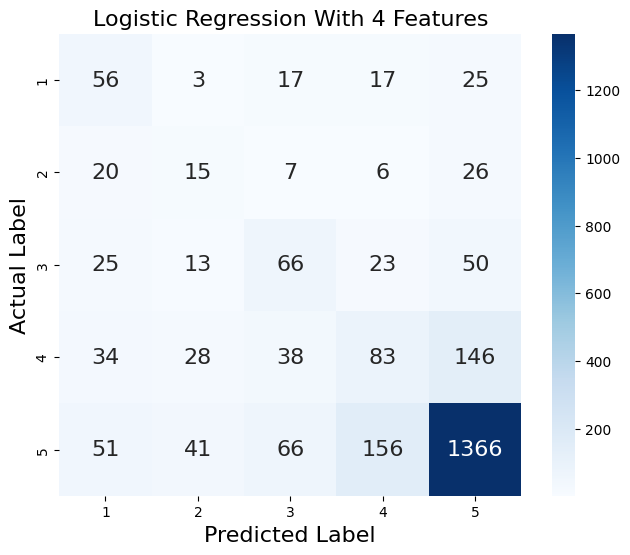

In [ ]:
# Define a function to map the numeric labels to bin ranges
def map_label_to_range(label):
  if label == 0:
      return '1'
  elif label == 1:
      return '2'
  elif label == 2:
      return '3'
  elif label == 3:
      return '4'
  elif label == 4:
      return '5'
# Prepare data for confusion matrix
predictions_pd4 = test_results.select('rating_bracket', 'prediction').toPandas()
predictions_pd4.to_csv('LR_4features.csv', index=False)
predictions_pd4['rating_bracket'] = predictions_pd4['rating_bracket'].apply(map_label_to_range)
predictions_pd4['prediction'] = predictions_pd4['prediction'].apply(map_label_to_range)

# Define labels in the desired order
labels = ['1', '2', '3', '4', '5']

# Plot Confusion Matrix
plt.figure(figsize=(8, 6))
cm = confusion_matrix(predictions_pd4['rating_bracket'], predictions_pd4['prediction'], labels=labels)
sns.heatmap(cm, annot=True, fmt="d", square=True, cmap='Blues', xticklabels=labels, yticklabels=labels,annot_kws={"size": 16})
plt.ylabel('Actual Label', fontsize=16)
plt.xlabel('Predicted Label', fontsize=16)
plt.title('Logistic Regression With 4 Features', fontsize=16)
plt.show()

## Model Optimization

In [ ]:
# VectorAssembler to combine feature columns
assembler = VectorAssembler(inputCols=["review_features","asins_ohe", "categories_ohe","sentiment_score","product_average_rating"], outputCol="features")
# Base classifier for OneVsRest
base_classifier = LinearSVC()

# Define the models
models = {
    "Multiclass Linear SVM": OneVsRest(classifier=base_classifier, featuresCol='features', labelCol='rating_bracket')
    }
# Define evaluators
evaluator_accuracy = MulticlassClassificationEvaluator(predictionCol="prediction", labelCol='rating_bracket', metricName="accuracy")
evaluator_f1 = MulticlassClassificationEvaluator(predictionCol="prediction", labelCol='rating_bracket', metricName="f1")
evaluator_precision = MulticlassClassificationEvaluator(predictionCol="prediction", labelCol='rating_bracket', metricName="weightedPrecision")
evaluator_recall = MulticlassClassificationEvaluator(predictionCol="prediction", labelCol='rating_bracket', metricName="weightedRecall")

# Loop through models
for model_name, model in models.items():
    # Pipeline combining preprocessing and model
    pipeline = Pipeline(stages=[tokenizer, remover, hashingTF, assembler, model])

    # Fit the model
    pipeline_model = pipeline.fit(train_data)

    # Predict on train and test data
    test_results = pipeline_model.transform(test_data)
    train_results = pipeline_model.transform(train_data)

    # Compute accuracy, F1 score, precision, and recall
    accuracy = evaluator_accuracy.evaluate(test_results)
    f1 = evaluator_f1.evaluate(test_results)
    precision = evaluator_precision.evaluate(test_results)
    recall = evaluator_recall.evaluate(test_results)


    # Print evaluation metrics
    print(f"{model_name}: Test Accuracy = {accuracy}, Test F1 = {f1}")
    print(f"{model_name}:Test Precision = {precision}, Test Recall = {recall}")

Multiclass Linear SVM: Test Accuracy = 0.748107653490328, Test F1 = 0.7359619248916317
Multiclass Linear SVM:Test Precision = 0.7303977050880959, Test Recall = 0.748107653490328


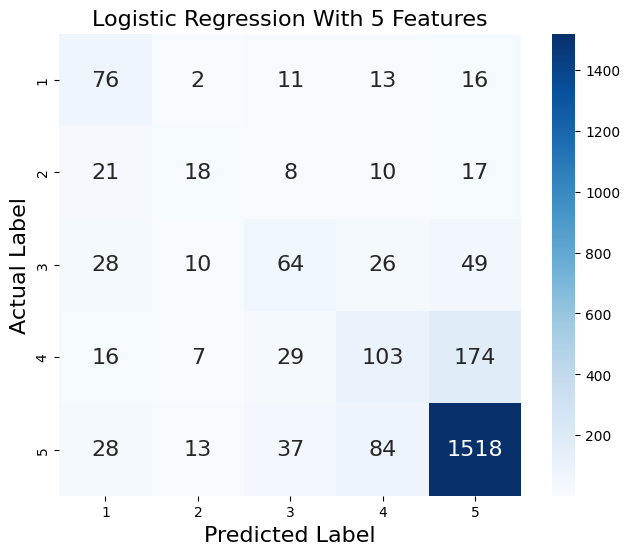

In [ ]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, precision_recall_curve, roc_curve
import seaborn as sns
# Define a function to map the numeric labels to bin ranges
def map_label_to_range(label):
  if label == 0:
      return '1'
  elif label == 1:
      return '2'
  elif label == 2:
      return '3'
  elif label == 3:
      return '4'
  elif label == 4:
      return '5'
# Prepare data for confusion matrix
predictions_pd5 = test_results.select('rating_bracket', 'prediction').toPandas()
predictions_pd5.to_csv('SVM_5features.csv', index=False)
predictions_pd5['rating_bracket'] = predictions_pd5['rating_bracket'].apply(map_label_to_range)
predictions_pd5['prediction'] = predictions_pd5['prediction'].apply(map_label_to_range)

# Define labels in the desired order
labels = ['1', '2', '3', '4', '5']

# Plot Confusion Matrix
plt.figure(figsize=(8, 6))
cm = confusion_matrix(predictions_pd5['rating_bracket'], predictions_pd5['prediction'], labels=labels)
sns.heatmap(cm, annot=True, fmt="d", square=True, cmap='Blues', xticklabels=labels, yticklabels=labels,annot_kws={"size": 16})
plt.ylabel('Actual Label', fontsize=16)
plt.xlabel('Predicted Label', fontsize=16)
plt.title('Logistic Regression With 5 Features', fontsize=16)
plt.show()

In [ ]:
spark.stop

<bound method SparkSession.stop of <pyspark.sql.session.SparkSession object at 0x7d126f367c10>>